# Defining the Ising model

In [1]:
from simuq.qsystem import QSystem
from simuq.environment import qubit

def Ising(N, T, J, h):
    qs = QSystem()
    q = [qubit(qs) for _ in range(N)]
    H = 0
    for j in range(N):
        for k in range(N):
            H += J[j, k] * q[j].Z * q[k].Z
    for j in range(N):
        H += h[j] * q[j].X
    qs.add_evolution(H, T)
    return qs

In [2]:
import numpy as np

N, T = 4, 1

h = np.array([1 for j in range(N)])
J_chain = np.zeros((N, N))
for j in range(N - 1):
    J_chain[j, j + 1] = 1
Ising_chain = Ising(N, T, J_chain, h)

J_cycle= np.copy(J_chain)
J_cycle[0, N - 1] = 1
Ising_cycle = Ising(N, T, J_cycle, h)

# Function to determine the fidelity of the results

In the following, we will use total variational distance to evaluate the simulation results, defined for two distribution $P_1, P_2$ as $$TV(P_1, P_2)=\frac{1}{2}\sum_x |P_1[x]-P_2[x]|.$$ We realize it as a function:

In [3]:
def TV(P1, P2):
    keys = set(P1.keys()).union(P2.keys())
    s = 0
    for k in keys :
        if k not in P1.keys():
            s += P2[k]
        elif k not in P2.keys():
            s += P1[k]
        else :
            s += abs(P1[k] - P2[k])
    return s / 2

# Classical simulation for comparison

In [4]:
from simuq.qutip import QuTiPProvider

qtpp = QuTiPProvider()

In [5]:
qtpp.compile(Ising_chain)

Compiled.


In [6]:
qtpp.run()

Solved.


In [7]:
res_chain_gt = qtpp.results()

### IBM's Transmon Systems

Here we access IBM’s devices via qiskit. Similarly, we create an IBMprovider. 

In [8]:
from ibm_provider_custom import IBMProvider
ibm = IBMProvider(from_file="ibm_API_key", hub="ibm-q", group="open", project="main")

In [9]:
ibm.compile(Ising_chain, backend="ibm_lagos", trotter_num=4)

In [10]:
ibm.run(on_simulator=True)

In [11]:
res_ibm_chain = ibm.results(on_simulator=True)
TV(res_chain_gt, res_ibm_chain)

0.14936124324762293

A noisy simulation for IBM devices is also possible. We repeat the above procedure to see how noises will likely affect the results.

In [12]:
ibm.run(on_simulator=True, with_noise=True)

In [13]:
res_ibm_chain_noisy = ibm.results(on_simulator=True)
TV(res_chain_gt, res_ibm_chain_noisy)

0.14264401556785516

In [14]:
ibm.run()

In [21]:
res_ibm_chain_real = ibm.results(on_simulator=False)
TV(res_chain_gt, res_ibm_chain_real)

0.3640076521474375

In [ ]:
ibm.supported_backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q', group='open', project='main')>]


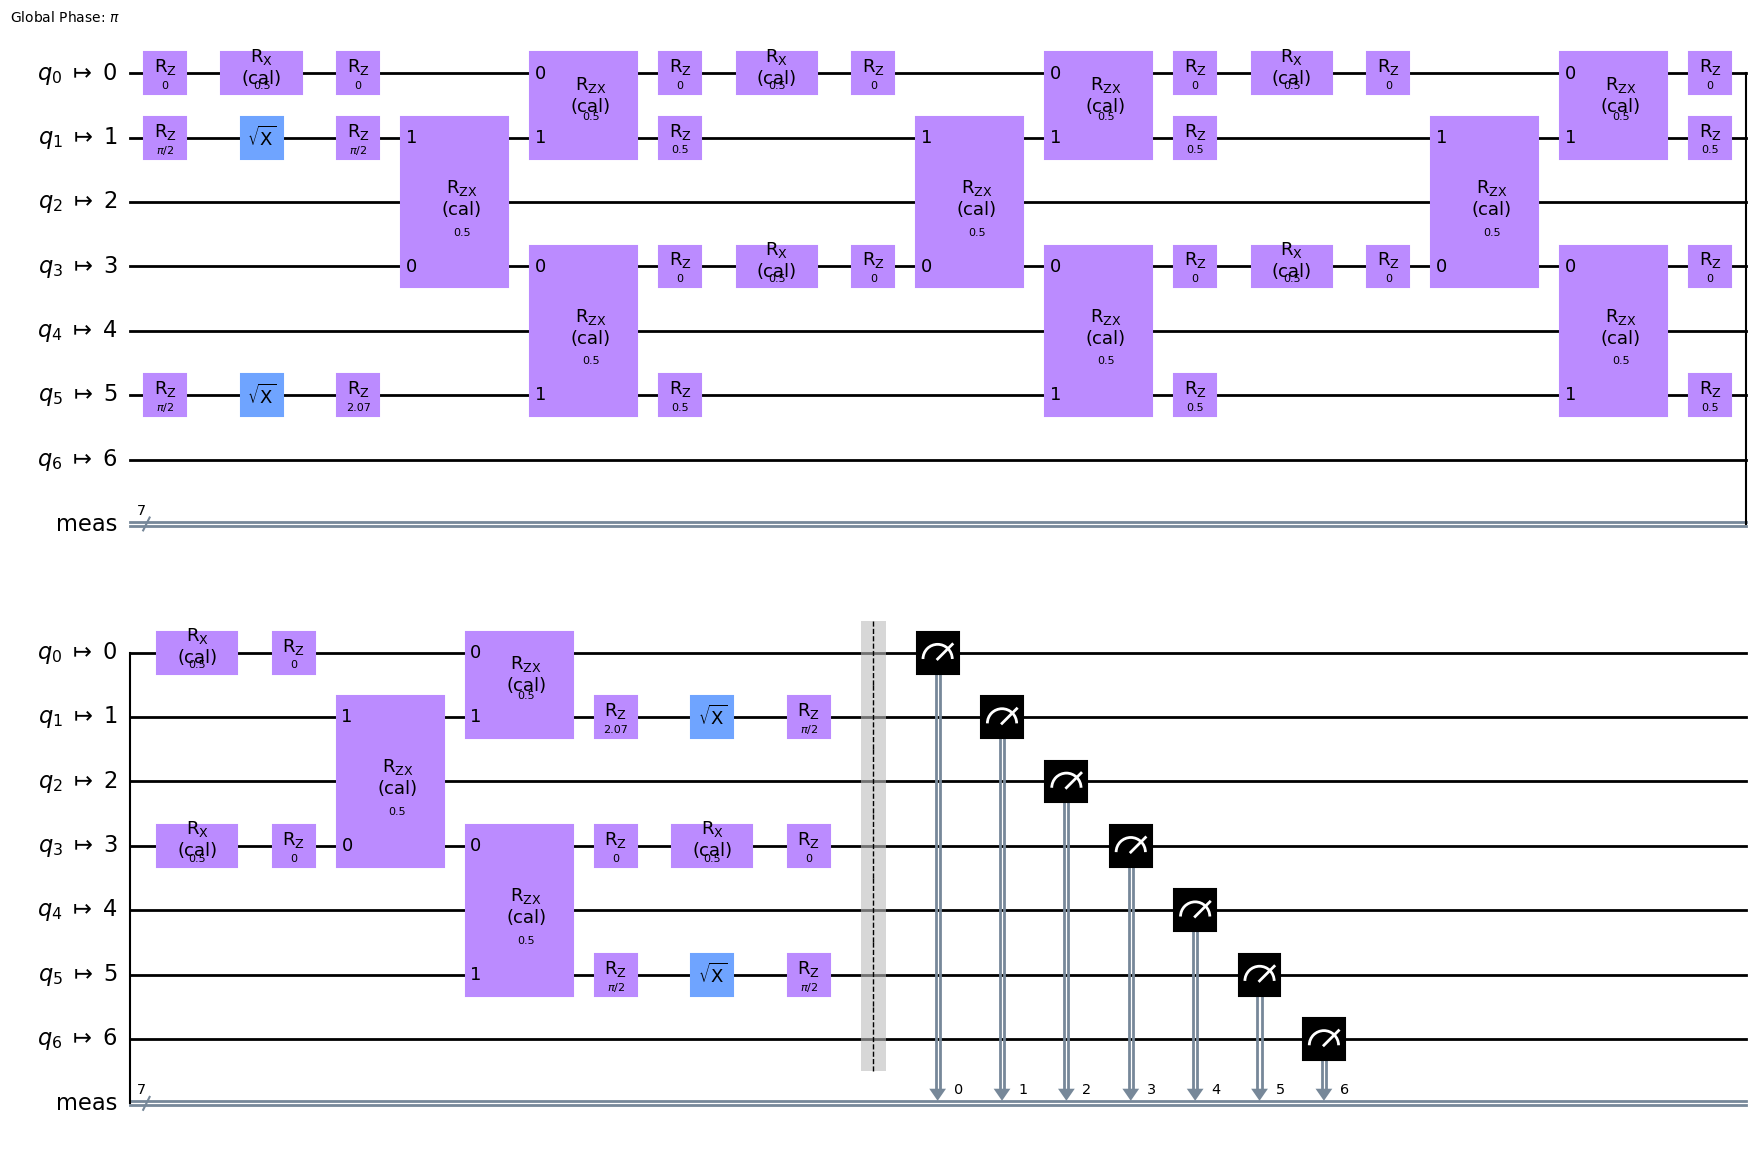

In [ ]:
ibm.prog.draw('mpl')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

with open("ibm_API_key", "r") as f:
    api_key = f.readline().strip()

QiskitRuntimeService.save_account(channel="ibm_quantum", token=api_key)

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum",instance="ibm-q/open/main")
backend = service.backend("ibmq_qasm_simulator")

In [ ]:
from qiskit_ibm_runtime import Sampler
sampler = Sampler(backend=backend)

In [ ]:
job = sampler.run(ibm.prog)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

QpyError: "Object type '<class 'qiskit.pulse.schedule.Schedule'>' is not supported in Program namespace."